Found existing installation: torch 1.10.0+cu111
Uninstalling torch-1.10.0+cu111:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.10.0+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
Proceed (y/n)? y

ERROR: Operation cancelled by user
<!DOCTYPE html>
<html>
<head>
<meta http-equiv="Content-type" content="text/html; charset=utf-8">
<meta http-equiv="Content-Security-Policy" content="default-src 'none'; style-src 'unsafe-inline'; img-src data:; connect-src 'self'">
<title>Page not found &middot; GitHub Pages</title>
<style type="text/css" media="screen">
      body {
        background-color: #f1f1f1;
        margin: 0;
        font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
      }

      .container { margin: 50px auto 40px auto; width: 600px; text-align: center; }

      a
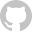
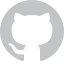

In [1]:
!pip uninstall torch
!curl -s https://course.fast.ai/setup/colab

In [12]:
import torch
from torch import nn, optim
import argparse
import numpy as np
import pandas as pd
from collections import Counter
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import gc
# from model import Model
# from dataset import Dataset

print(torch.cuda.is_available())
print(torch.cuda.current_device())



True
0


In [3]:
### Class: Dataset 

class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        device,
        args,
    ):
        self.device = device
        
        self.args = args
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        text = []
        with open('eminem_lyrics.txt', encoding="utf-8") as f:
        # with open('eminem_punc_cleaned.txt', encoding="utf-8") as f:
            for line in f:
                text += line.split(" ")
        return text # we return a list of string

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.args[2]
        # return len(self.words_indexes) - self.args.sequence_length

    def __getitem__(self, index):
        return (
            # torch.tensor(self.words_indexes[index:index+self.args.sequence_length]),
            # torch.tensor(self.words_indexes[index+1:index+self.args.sequence_length+1]),
            torch.tensor(self.words_indexes[index:index+self.args[2]]).to(self.device),
            torch.tensor(self.words_indexes[index+1:index+self.args[2]+1]).to(self.device),
            # torch.tensor(self.words_indexes[index:index+self.args[2]], device=device),
            # torch.tensor(self.words_indexes[index+1:index+self.args[2]+1], device=device),
        )

In [4]:
### Class: Model

class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 1

        self.device = dataset.device

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers
            # dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size).to(self.device),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size).to(self.device))

In [5]:
### function: train

def train(dataset, model, args):
    model.train()

    # dataloader = DataLoader(dataset, batch_size=args.batch_size)
    dataloader = DataLoader(dataset, batch_size=args[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.93)

    # for epoch in tqdm(range(args.max_epochs), total=args.max_epochs):
    for epoch in tqdm(range(args[0]), total=args[0], position=0, leave=True):
        state_h, state_c = model.init_state(args[2])

        pbar = tqdm(enumerate(dataloader), total=len(dataloader), position=0, leave=True)
        pbar.set_description("Epoch {}".format(epoch))
        for cnt, (x, y) in pbar:
            x = x.to(model.device)
            y = y.to(model.device)
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.item())
        
        scheduler.step()


In [6]:
### function: predict

def predict(dataset, model, text, num_lines=16, min_words=5, max_words=15):
    # model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))
    cur_word_cnt = len(words)
    cur_line_cnt = i = 0

    while cur_line_cnt < num_lines:
        while cur_word_cnt <= max_words:
            x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]]).to(model.device)
            # x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]], device=device)
            y_pred, (state_h, state_c) = model(x, (state_h, state_c))

            last_word_logits = y_pred[0][-1]
            p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()
            word_index = np.random.choice(len(last_word_logits), p=p)
            if dataset.index_to_word[word_index][-1] == '\n':
                if cur_word_cnt < min_words:
                    while dataset.index_to_word[word_index][-1] == '\n':
                        word_index = np.random.choice(len(last_word_logits), p=p)
                else:
                    cur_word_cnt = 0
                    cur_line_cnt += 1
                words.append(dataset.index_to_word[word_index])
            elif cur_word_cnt >= max_words:
                words.append('\n')
                cur_word_cnt = 0
                cur_line_cnt += 1
            else:
                words.append(dataset.index_to_word[word_index])
            cur_word_cnt += 1
            if cur_line_cnt > num_lines:
                break
            i += 1

    return words

In [21]:
### WHAT WE ACTUALLY NEED TO RUN: ###

## Set up args
# parser = argparse.ArgumentParser()
# parser.add_argument('--max-epochs', type=int, default=10)
# parser.add_argument('--batch-size', type=int, default=128)
# parser.add_argument('--sequence-length', type=int, default=8)
# args = parser.parse_args()
# (max-epochs, batch-size, sequence-length)
torch.cuda.empty_cache()
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

## Set up dataset
max_epochs = 10
batch_size = 1024
sequence_length = 16
args = (max_epochs, batch_size, sequence_length)
dataset = Dataset(device, args)
# dataset.to(device)

## Set up model
model = Model(dataset)
model = model.to(device)

## Train model
train(dataset, model, args)

100%|██████████| 10/10 [51:25<00:00, 308.51s/it]


In [20]:
del model
gc.collect()

2257

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [31]:
# Generate text
num_lines = 8
text = "so crack a bottle"
prediction = " ".join(predict(dataset, model, text=text, num_lines=num_lines))
print(" [Eminem]:")
print("", prediction)

 [Eminem]:
 so crack a bottle father got kid
 arrested molested myself with two albums that's why i'm moving right now 'cause you 
 and that's why he dish it to you
 don't meet to eat your funeral on the block are the incredible
 with ken kaniff who slim shady like a hot paper rather and i don't 
 in a fuck about 26 shit and i'ma get down to say 'fore i 
 it's brain like this crack too
 such a mental hospital with three spokes
 sticking down to sleep medication

